In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# transfer learning
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Base directory and subdirectories for the dataset
base_dir = "/kaggle/input/pneumonia"
train_dir = os.path.join(base_dir, "Pneumonia/train")
val_dir = os.path.join(base_dir, "Pneumonia/val")
test_dir = os.path.join(base_dir, "Pneumonia/test")

# Ensure the directories exist
if not os.path.exists(base_dir):
    raise FileNotFoundError(f"Base directory not found: {base_dir}")
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Train directory not found: {train_dir}")
if not os.path.exists(val_dir):
    raise FileNotFoundError(f"Validation directory not found: {val_dir}")
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Test directory not found: {test_dir}")

# Image Data Generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Calculate class weights to handle imbalanced data
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model with EarlyStopping and ReduceLROnPlateau
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Compile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

model.save("/kaggle/working/pneumonia_model.h5")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions for the test set
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = (y_pred > 0.5).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_gen.class_indices.keys()))

# AUROC Score
roc_auc = roc_auc_score(y_true, y_pred)
print(f"AUROC: {roc_auc:.2f}")

# Plot ROC Curve
RocCurveDisplay.from_predictions(y_true, y_pred)
plt.title('ROC Curve')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# ==========================
# Predicting new images
# ==========================

# Directory of new images
new_images_dir = "/kaggle/input/data-radiolog/data pneumonia radiolog 111124/data pneumonia radiolog 111124/data numbered14-10-24"
output_mapping = {0: "Normal", 1: "Pneumonia"}

# Function to preprocess and predict a single image
def predict_image(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale pixel values
    prediction = model.predict(img_array)
    predicted_class = 1 if prediction[0][0] > 0.5 else 0
    confidence = prediction[0][0] if predicted_class == 1 else 1 - prediction[0][0]
    return output_mapping[predicted_class], confidence

# Loop through new images and predict
for subdir, _, files in os.walk(new_images_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(subdir, file)
            predicted_label, confidence = predict_image(image_path, model)
            print(f"Image: {image_path}")
            print(f"Predicted: {predicted_label}, Confidence: {confidence:.2f}")
            print("-" * 40)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.4956 - loss: 0.7017 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.4859 - loss: 0.6911 - val_accuracy: 0.5000 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.3913 - loss: 0.6926 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.4569 - loss: 0.6945 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.4936 - loss: 0.7007 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 2.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.5010 - loss: 0.6872 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 2.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5190 - loss: 0.701

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


TensorFlow version: 2.17.0
GPU available: []
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4836 - loss: 0.6986
Epoch 1: val_loss improved from inf to 0.69316, saving model to /kaggle/working/pneumonia_fullmodel.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.4835 - loss: 0.6985 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3760 - loss: 0.7033
Epoch 2: val_loss did not improve from 0.69316
163/163 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.3759 - loss: 0.7033 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5777 - loss: 0.6970
Epoch 3: val_loss improved from 0.69316 to 0.69315, saving model to /kaggle/working/pneumonia_fullmodel.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.5772 - loss: 0.6970 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.48

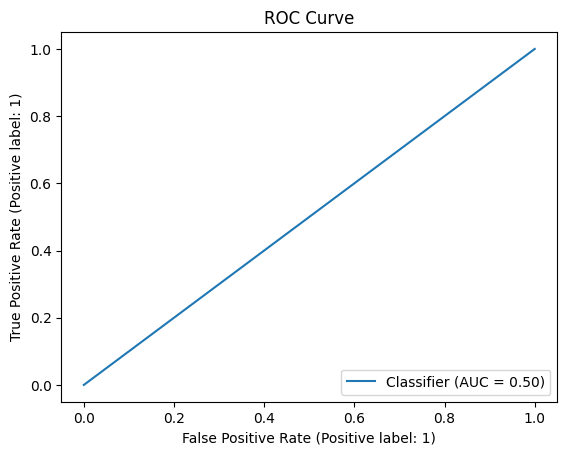

Using conv layer: top_conv

 990. DEDI KUSNANDAR_20220223.jpg


TypeError: list indices must be integers or slices, not tuple

In [2]:
# ══════════════════════════════════════════════
# 1. INSTALL & IMPORT
# ══════════════════════════════════════════════
!pip install tensorflow --quiet

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from tensorflow.keras import Input, Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Ensure TF sees a GPU if available
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# ══════════════════════════════════════════════
# 2. PATHS & PARAMETERS
# ══════════════════════════════════════════════
BASE_DIR      = "/kaggle/input/pneumonia"
TRAIN_DIR     = os.path.join(BASE_DIR, "Pneumonia/train")
VAL_DIR       = os.path.join(BASE_DIR, "Pneumonia/val")
TEST_DIR      = os.path.join(BASE_DIR, "Pneumonia/test")
NEW_IMAGES    = "/kaggle/input/data-radiolog/data pneumonia radiolog 111124/data pneumonia radiolog 111124/data numbered14-10-24"

IMG_SIZE      = (224, 224)
BATCH_SIZE    = 32
EPOCHS_1      = 10   # initial transfer learning
EPOCHS_2      = 10   # fine‑tuning
FULL_MODEL_FP = "/kaggle/working/pneumonia_fullmodel.keras"

# ══════════════════════════════════════════════
# 3. DATA GENERATORS
# ══════════════════════════════════════════════
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen= ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)
val_gen   = val_datagen.flow_from_directory(
    VAL_DIR,   target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)
test_gen  = test_datagen.flow_from_directory(
    TEST_DIR,  target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight('balanced',
                          classes=np.unique(train_gen.classes),
                          y=train_gen.classes)
class_weights = dict(enumerate(cw))

# ══════════════════════════════════════════════
# 4. BUILD & TRAIN MODEL (Transfer + Fine‑Tune)
# ══════════════════════════════════════════════
# Functional API
inp = Input(shape=(*IMG_SIZE, 3))
base = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=inp)
x = GlobalAveragePooling2D()(base.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid')(x)
model = Model(inp, out)

# Phase 1: Freeze base
base.trainable = False
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint(FULL_MODEL_FP, save_best_only=True, verbose=1)  # full model saved as .keras
]
model.fit(train_gen, validation_data=val_gen,
          epochs=EPOCHS_1, class_weight=class_weights, callbacks=callbacks)

# Phase 2: Fine‑tune
base.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_gen, validation_data=val_gen,
          epochs=EPOCHS_2, class_weight=class_weights, callbacks=callbacks)

# Ensure final best model is saved
model.save(FULL_MODEL_FP)

# ══════════════════════════════════════════════
# 5. LOAD FULL MODEL & EVALUATE
# ══════════════════════════════════════════════
model = tf.keras.models.load_model(FULL_MODEL_FP, compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Metrics on test set
y_true       = test_gen.classes
y_pred_prob  = model.predict(test_gen, verbose=0)
y_pred       = (y_pred_prob > 0.5).astype(int)

# Print
print(f"Test Accuracy: {model.evaluate(test_gen, verbose=0)[1]*100:.2f}%")
print("AUROC:", roc_auc_score(y_true, y_pred_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=['Normal','Pneumonia'], zero_division=0))
RocCurveDisplay.from_predictions(y_true, y_pred_prob)
plt.title("ROC Curve")
plt.show()

# ══════════════════════════════════════════════
# 6. GRAD‑CAM IMPLEMENTATION
# ══════════════════════════════════════════════
# Find last Conv2D layer
last_conv = next(layer.name for layer in reversed(base.layers)
                 if isinstance(layer, tf.keras.layers.Conv2D))
print("Using conv layer:", last_conv)

def get_img_array(path, size=IMG_SIZE):
    img = load_img(path, target_size=size)
    arr = img_to_array(img)/255.0
    return np.expand_dims(arr,0), img

def make_gradcam_heatmap(img_array, model, layer_name, pred_index=None):
    grad_model = Model([model.input],
                       [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]
    grads = tape.gradient(loss, conv_out)
    pooled = tf.reduce_mean(grads, axis=(0,1,2))
    conv_out = conv_out[0]
    heatmap = conv_out @ pooled[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap,0)/(tf.reduce_max(heatmap)+1e-8)
    return heatmap.numpy()

def display_and_save_gradcam(path, model, layer_name, out_dir="gradcam_outputs"):
    os.makedirs(out_dir, exist_ok=True)
    arr, orig_img = get_img_array(path)
    hm = make_gradcam_heatmap(arr, model, layer_name)
    hm = cv2.resize(hm, IMG_SIZE)
    hm = np.uint8(255*hm)
    hm_color = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
    overlay = hm_color*0.4 + cv2.cvtColor(np.array(orig_img), cv2.COLOR_RGB2BGR)
    # display
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.title("Original"); plt.imshow(orig_img); plt.axis('off')
    plt.subplot(1,2,2); plt.title("Grad-CAM"); plt.imshow(overlay[...,::-1]); plt.axis('off')
    plt.show()
    # save
    fname = os.path.basename(path)
    cv2.imwrite(f"{out_dir}/gradcam_{fname}", overlay)
    print("Saved gradcam to", f"{out_dir}/gradcam_{fname}")

# ══════════════════════════════════════════════
# 7. APPLY GRAD‑CAM TO 10 NEW IMAGES
# ══════════════════════════════════════════════
count = 0
for root, _, files in os.walk(NEW_IMAGES):
    for f in files:
        if f.lower().endswith(('.jpg','.jpeg','.png')):
            fullp = os.path.join(root, f)
            print("\n", f)
            display_and_save_gradcam(fullp, model, last_conv)
            count += 1
            if count>=10: break
    if count>=10: break